In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Load datasets
drift = pd.read_csv('data/drift_data.csv')
excursion_data = pd.read_csv('data/excursion_data.csv')

In [3]:
def train_and_evaluate(X, y, dataset_name):
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define hyperparameter grids
    param_grids = {
        "Random Forest": {
            "n_estimators": [100, 200],
            "max_depth": [10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        },
        "XGBoost": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1],
            "max_depth": [3, 5],
            "subsample": [0.8, 1.0]
        }
    }
    
    # Initialize models
    models = {
        "Random Forest": RandomForestRegressor(random_state=42),
        "XGBoost": xgb.XGBRegressor(random_state=42, objective="reg:squarederror")
    }
    
    results = {}
    best_params = {}
    feature_importances = {}

    for name, model in models.items():
        print(f"Performing hyperparameter tuning for {name} on {dataset_name} dataset...")
        grid_search = GridSearchCV(
            model, param_grid=param_grids[name], scoring="neg_mean_squared_error", cv=cv, n_jobs=-1
        )
        grid_search.fit(X_train, y_train)

        # Best model evaluation
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        # Store results
        best_params[name] = grid_search.best_params_
        results[name] = {"Test RMSE": rmse, "Test R²": r2}

        # Feature importance
        importance = best_model.feature_importances_
        feature_importances[name] = importance
        
        # Plot Feature Importance
        sorted_idx = np.argsort(importance)[::-1]
        sorted_features = np.array(X.columns)[sorted_idx]
        sorted_importances = importance[sorted_idx]

        plt.figure(figsize=(8, 6))
        plt.barh(sorted_features, sorted_importances, color="lightblue", edgecolor="black")
        plt.xlabel("Importance Score")
        plt.ylabel("Features")
        plt.title(f"{name} - Feature Importance ({dataset_name} dataset)")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

        # Plot Predicted vs Actual
        plt.figure(figsize=(8, 4))
        sns.scatterplot(x=y_test, y=y_pred, color="coral", edgecolor="k")
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=1.5, label="Ideal")
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.title(f"{name} - Predicted vs Actual ({dataset_name} dataset)")
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

        print(f"{name} - {dataset_name} dataset: Test RMSE: {rmse:.4f}, Test R²: {r2:.4f}")

    return results, best_params, feature_importances

Performing hyperparameter tuning for Random Forest on Full dataset...


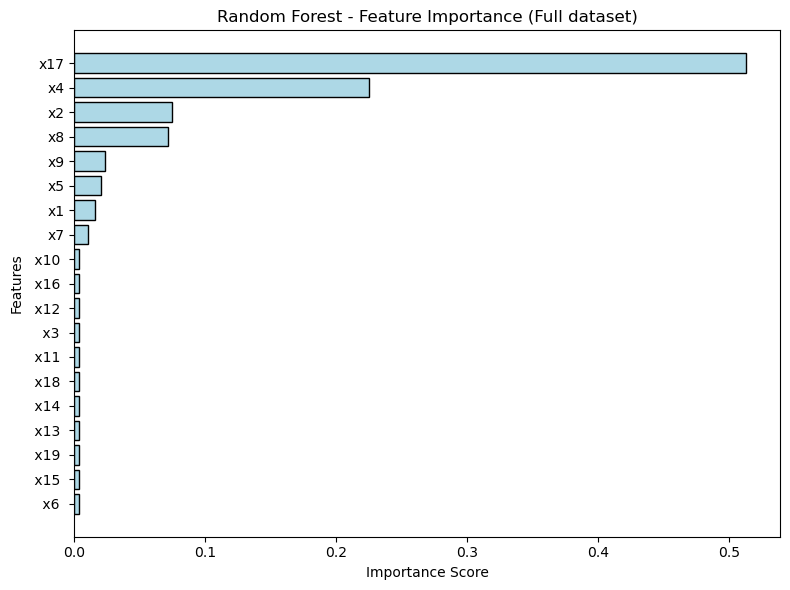

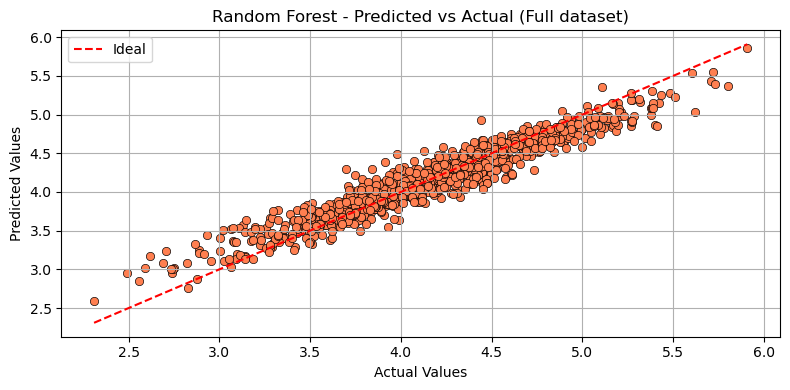

Random Forest - Full dataset: Test RMSE: 0.1725, Test R²: 0.9049
Performing hyperparameter tuning for XGBoost on Full dataset...


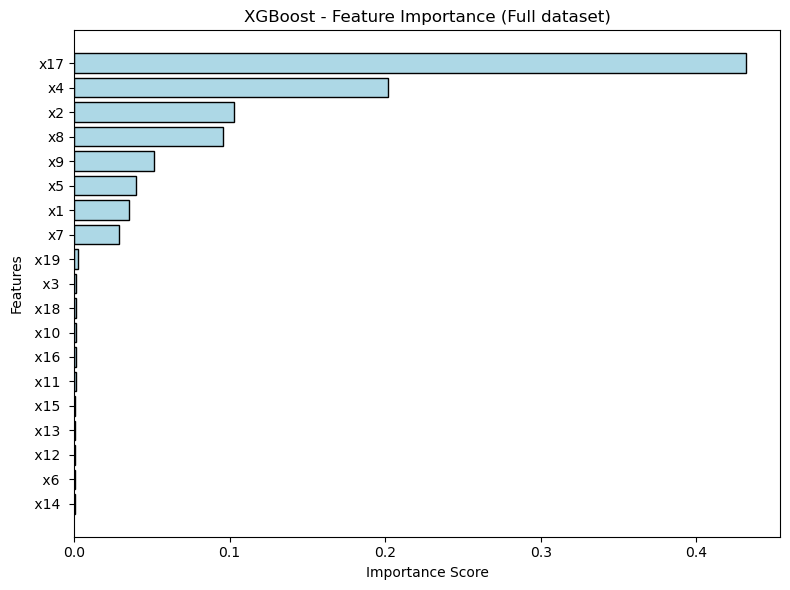

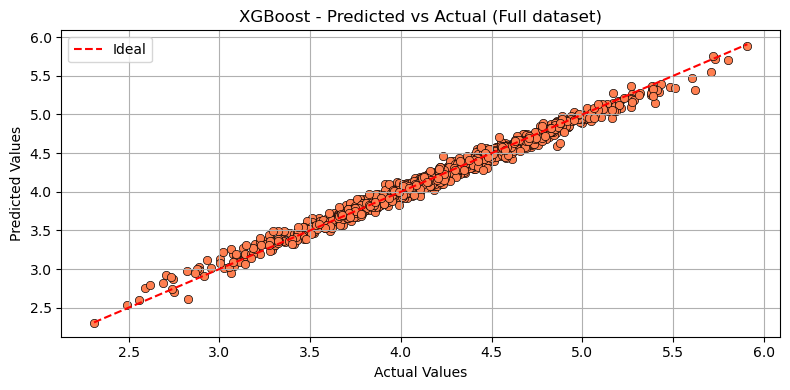

XGBoost - Full dataset: Test RMSE: 0.0679, Test R²: 0.9853


In [4]:
X_full = drift.drop(columns=['outcome'])
y_full = drift['outcome']
full_results, full_best_params, full_feature_importances = train_and_evaluate(X_full, y_full, "Full")


Performing hyperparameter tuning for Random Forest on Reduced dataset...


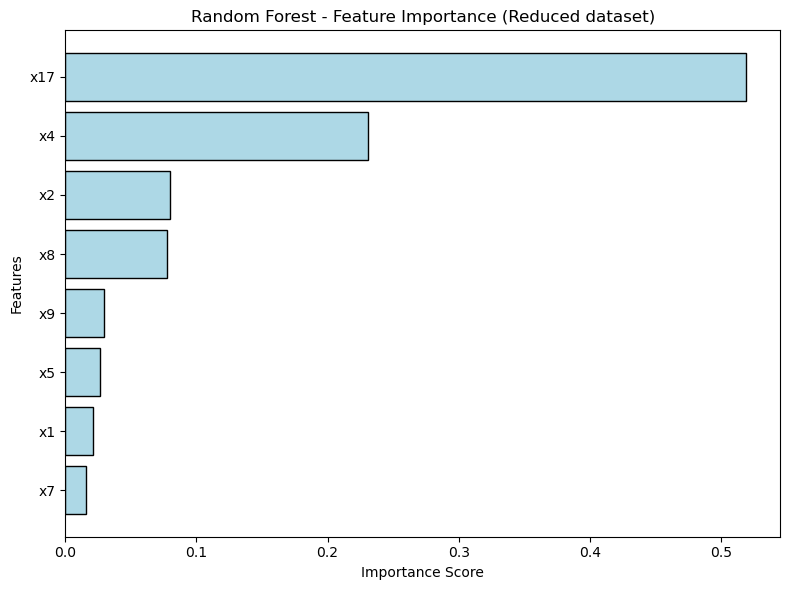

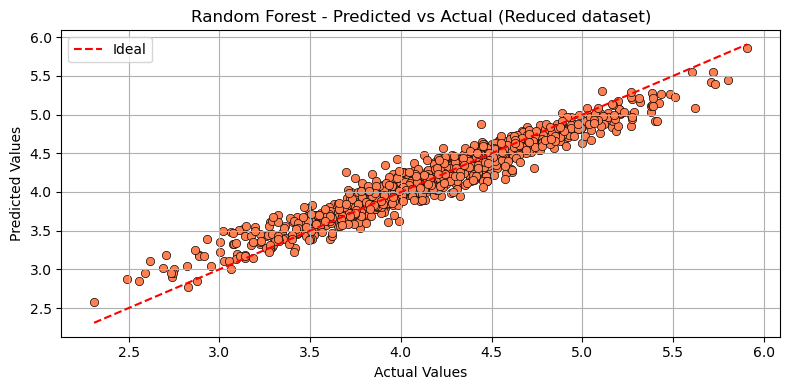

Random Forest - Reduced dataset: Test RMSE: 0.1533, Test R²: 0.9249
Performing hyperparameter tuning for XGBoost on Reduced dataset...


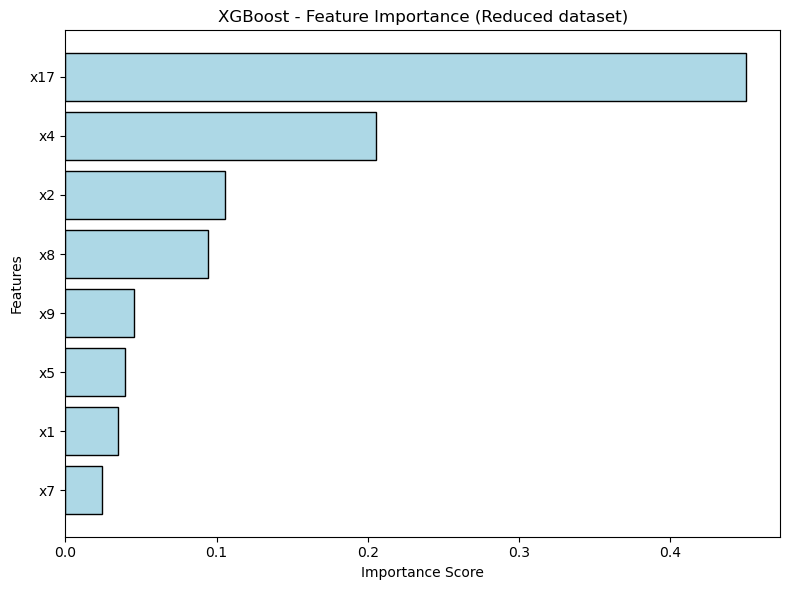

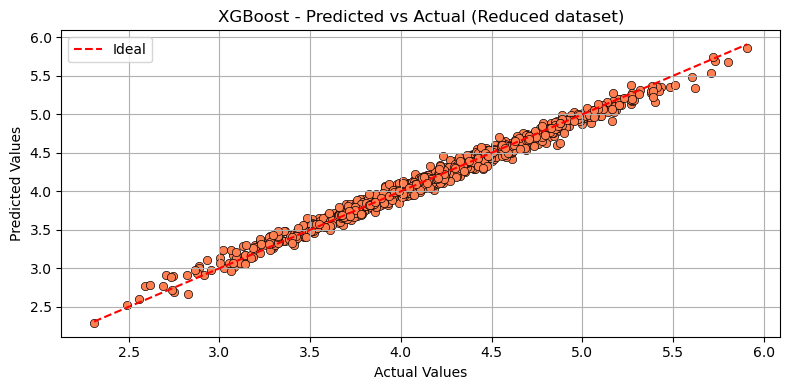

XGBoost - Reduced dataset: Test RMSE: 0.0669, Test R²: 0.9857


In [5]:
drift_reduced = drift.copy()
drift_reduced.drop(columns=[' x3 ', ' x6 ', ' x10 ', ' x11 ', ' x12 ', ' x13 ', ' x14 ', ' x15 ', ' x16 ', ' x18 ', ' x19 '], axis=1, inplace=True)

X_reduced = drift_reduced.drop(columns=['outcome'])
y_reduced = drift_reduced['outcome']
reduced_results, reduced_best_params, reduced_feature_importances = train_and_evaluate(X_reduced, y_reduced, "Reduced")


In [6]:
print("\nResults Summary:")
full_results_df = pd.DataFrame(full_results).T
reduced_results_df = pd.DataFrame(reduced_results).T

print("\nFull Dataset Results:")
print(full_results_df)

print("\nReduced Dataset Results:")
print(reduced_results_df)


Results Summary:

Full Dataset Results:
               Test RMSE   Test R²
Random Forest   0.172475  0.904904
XGBoost         0.067871  0.985274

Reduced Dataset Results:
               Test RMSE   Test R²
Random Forest   0.153308  0.924866
XGBoost         0.066921  0.985684


In [7]:
# Compare best hyperparameters
print("\nBest Hyperparameters:")
print("\nFull Dataset:")
for name, params in full_best_params.items():
    print(f"{name}: {params}")

print("\nReduced Dataset:")
for name, params in reduced_best_params.items():
    print(f"{name}: {params}")


Best Hyperparameters:

Full Dataset:
Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

Reduced Dataset:
Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


In [9]:
def train_and_evaluate(X, y, dataset_name):
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define hyperparameter grids
    param_grids = {
        "Random Forest": {
            "n_estimators": [100, 200],
            "max_depth": [10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        },
        "XGBoost": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1],
            "max_depth": [3, 5],
            "subsample": [0.8, 1.0]
        }
    }
    
    # Initialize models
    models = {
        "Random Forest": RandomForestRegressor(random_state=42),
        "XGBoost": xgb.XGBRegressor(random_state=42, objective="reg:squarederror")
    }
    
    best_model_name = None
    best_model_rmse = float("inf")
    best_model_results = {}
    best_model_params = {}
    best_model = None
    best_feature_importances = None
    best_y_pred = None

    for name, model in models.items():
        print(f"Performing hyperparameter tuning for {name} on {dataset_name} dataset...")
        grid_search = GridSearchCV(
            model, param_grid=param_grids[name], scoring="neg_mean_squared_error", cv=cv, n_jobs=-1
        )
        grid_search.fit(X_train, y_train)

        # Best model evaluation
        best_candidate = grid_search.best_estimator_
        y_pred = best_candidate.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        # Check if this model is the best so far
        if rmse < best_model_rmse:
            best_model_rmse = rmse
            best_model_name = name
            best_model = best_candidate
            best_y_pred = y_pred
            best_model_results = {"Test RMSE": rmse, "Test R²": r2}
            best_model_params = grid_search.best_params_
            best_feature_importances = best_candidate.feature_importances_

    print(f"\nBest Model for {dataset_name} dataset: {best_model_name}")
    print(f"Best RMSE: {best_model_results['Test RMSE']:.4f}, R²: {best_model_results['Test R²']:.4f}")
    
    # Plot Feature Importance
    sorted_idx = np.argsort(best_feature_importances)[::-1]
    sorted_features = np.array(X.columns)[sorted_idx]
    sorted_importances = best_feature_importances[sorted_idx]

    plt.figure(figsize=(8, 6))
    plt.barh(sorted_features, sorted_importances, color="lightyellow", edgecolor="black")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.title(f"{best_model_name} - Feature Importance ({dataset_name})")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Plot Predicted vs Actual
    plt.figure(figsize=(8, 4))
    sns.scatterplot(x=y_test, y=best_y_pred, color="coral", edgecolor="k")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=1.5, label="Ideal")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{best_model_name} - Predicted vs Actual ({dataset_name})")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    # Store and return the best model results
    return best_model_name, best_model_results, best_model_params, best_feature_importances

Performing hyperparameter tuning for Random Forest on Full dataset...
Performing hyperparameter tuning for XGBoost on Full dataset...

Best Model for Full dataset: XGBoost
Best RMSE: 0.0679, R²: 0.9853


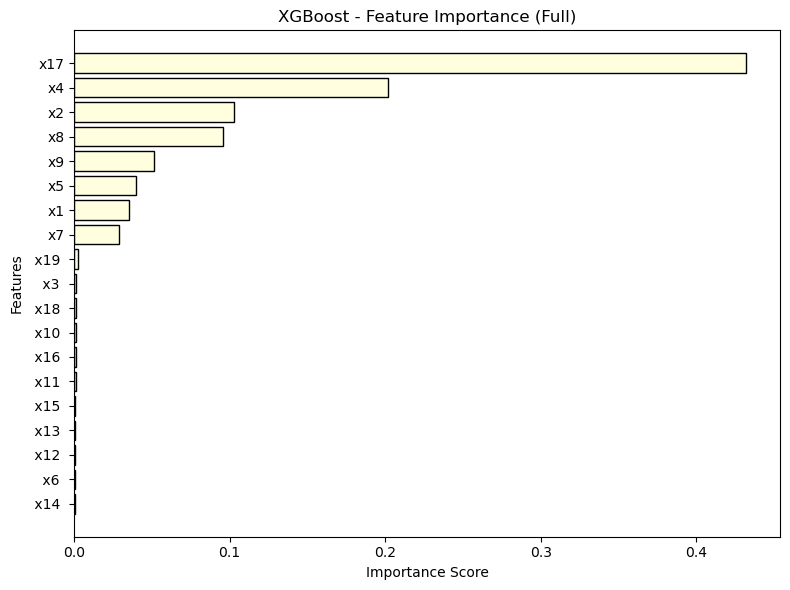

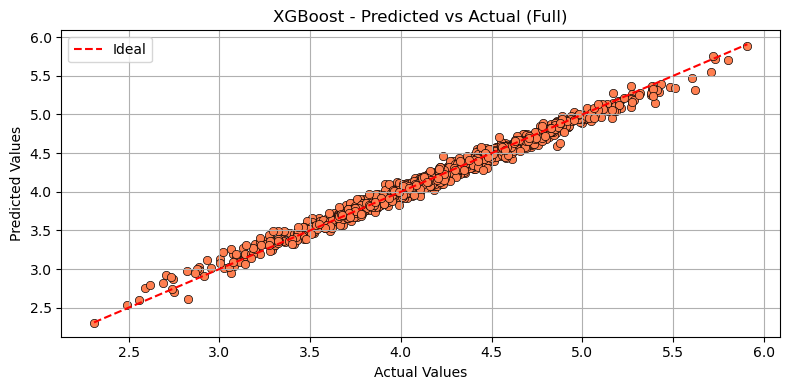

In [10]:
X_full = drift.drop(columns=['outcome'])
y_full = drift['outcome']
full_best_model, full_results, full_best_params, full_feature_importances = train_and_evaluate(X_full, y_full, "Full")

Performing hyperparameter tuning for Random Forest on Reduced dataset...
Performing hyperparameter tuning for XGBoost on Reduced dataset...

Best Model for Reduced dataset: XGBoost
Best RMSE: 0.0669, R²: 0.9857


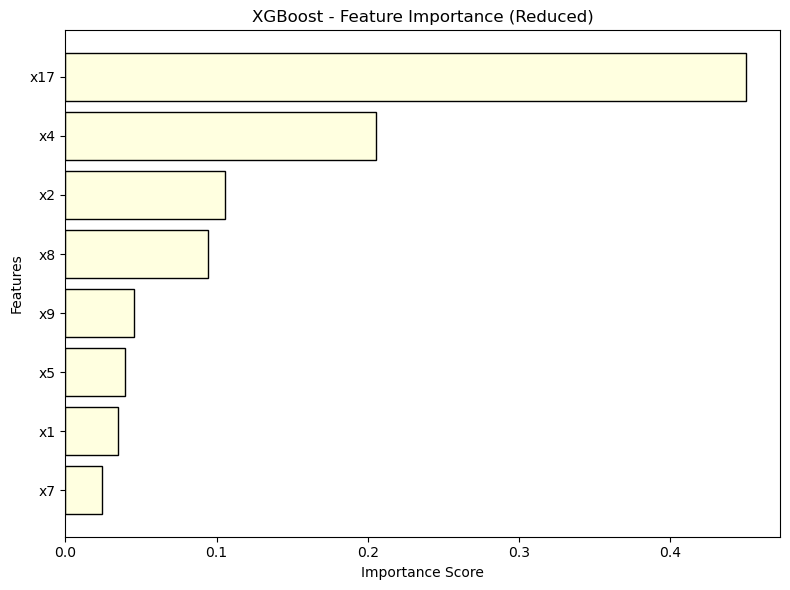

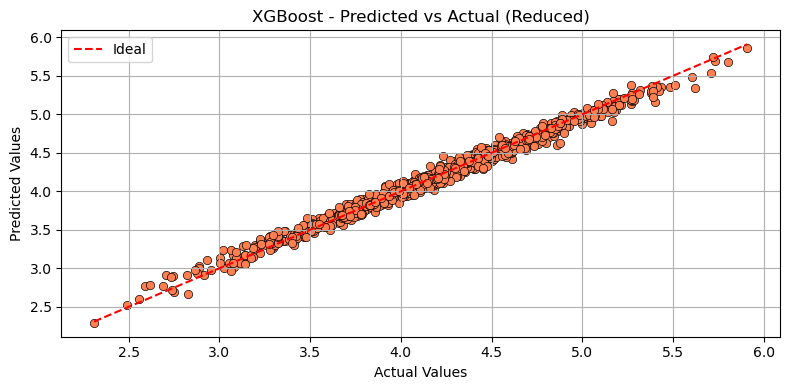

In [11]:
# Train on reduced dataset
drift_reduced = drift.copy()
drift_reduced.drop(columns=[' x3 ', ' x6 ', ' x10 ', ' x11 ', ' x12 ', ' x13 ', ' x14 ', ' x15 ', ' x16 ', ' x18 ', ' x19 '], axis=1, inplace=True)

X_reduced = drift_reduced.drop(columns=['outcome'])
y_reduced = drift_reduced['outcome']
reduced_best_model, reduced_results, reduced_best_params, reduced_feature_importances = train_and_evaluate(X_reduced, y_reduced, "Reduced")

In [12]:
if full_best_model == reduced_best_model:
    print(f"\nBest Model ({full_best_model}) remains consistent across both datasets.")



Best Model (XGBoost) remains consistent across both datasets.


In [14]:
comparison_df = pd.DataFrame({
    "Dataset": ["Full", "Reduced"],
    "Best Model": [full_best_model, reduced_best_model],
    "Test RMSE": [full_results["Test RMSE"], reduced_results["Test RMSE"]],
    "Test R²": [full_results["Test R²"], reduced_results["Test R²"]],
    "Best Parameters": [full_best_params, reduced_best_params]
})

print("\nComparison Summary:")
comparison_df



Comparison Summary:


,Dataset,Best Model,Test RMSE,Test R²,Best Parameters
0,Full,XGBoost,0.067871,0.985274,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
1,Reduced,XGBoost,0.066921,0.985684,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."


In [15]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize function
from sklearn.preprocessing import StandardScaler

In [17]:
drift = pd.read_csv('data/drift_data.csv')

# Full dataset
X_full = drift.drop(columns=['outcome'])
y_full = drift['outcome']

# Reduced dataset
X_reduced = drift.drop(columns=['outcome', ' x3 ', ' x6 ', ' x10 ', ' x11 ', ' x12 ', ' x13 ',
                                ' x14 ', ' x15 ', ' x16 ', ' x18 ', ' x19 '])
y_reduced = drift['outcome']

# Standardize
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)
X_reduced_scaled = scaler.fit_transform(X_reduced)

# Train-Test Split
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full_scaled, y_full, test_size=0.2, random_state=42)
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced_scaled, y_reduced, test_size=0.2, random_state=42)

In [19]:
# Hyperparameter grids
param_grid_xgb = {
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample": [0.6, 0.8, 1.0],
    "reg_alpha": [0, 0.1, 1],  # L1 Regularization
    "reg_lambda": [0, 0.1, 1]  # L2 Regularization
}

param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

# Train both models using hyperparameter tuning
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize models
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
}


In [20]:
def run_hyperparameter_tuning(X_train, y_train, X_test, y_test, model_name, param_grid):
    model = models[model_name]
    grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1, return_train_score=True)
    grid_search.fit(X_train, y_train)

    # Get results
    results = pd.DataFrame(grid_search.cv_results_)
    results["Train RMSE"] = np.sqrt(-results["mean_train_score"])
    results["Test RMSE"] = np.sqrt(-results["mean_test_score"])
    results["R² Train"] = results["mean_train_score"]
    results["R² Test"] = results["mean_test_score"]

    # Keep relevant columns
    results_summary = results[
        ['params', 'Train RMSE', 'Test RMSE', 'R² Train', 'R² Test']
    ]

    # Select the best model
    best_index = results_summary["Test RMSE"].idxmin()
    best_params = results_summary.iloc[best_index]

    return results_summary, grid_search.best_estimator_, best_params

In [21]:
rf_full_results, best_rf_full, best_rf_full_params = run_hyperparameter_tuning(X_train_full, y_train_full, X_test_full, y_test_full, "Random Forest", param_grid_rf)
xgb_full_results, best_xgb_full, best_xgb_full_params = run_hyperparameter_tuning(X_train_full, y_train_full, X_test_full, y_test_full, "XGBoost", param_grid_xgb)


In [22]:
# Run tuning for reduced dataset
rf_reduced_results, best_rf_reduced, best_rf_reduced_params = run_hyperparameter_tuning(X_train_reduced, y_train_reduced, X_test_reduced, y_test_reduced, "Random Forest", param_grid_rf)
xgb_reduced_results, best_xgb_reduced, best_xgb_reduced_params = run_hyperparameter_tuning(X_train_reduced, y_train_reduced, X_test_reduced, y_test_reduced, "XGBoost", param_grid_xgb)

In [23]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return y_pred, rmse, r2

y_pred_rf_full, rmse_rf_full, r2_rf_full = evaluate_model(best_rf_full, X_test_full, y_test_full)
y_pred_xgb_full, rmse_xgb_full, r2_xgb_full = evaluate_model(best_xgb_full, X_test_full, y_test_full)

y_pred_rf_reduced, rmse_rf_reduced, r2_rf_reduced = evaluate_model(best_rf_reduced, X_test_reduced, y_test_reduced)
y_pred_xgb_reduced, rmse_xgb_reduced, r2_xgb_reduced = evaluate_model(best_xgb_reduced, X_test_reduced, y_test_reduced)

In [24]:
best_models_summary = pd.DataFrame({
    "Model": ["Random Forest Full", "XGBoost Full", "Random Forest Reduced", "XGBoost Reduced"],
    "Best Hyperparameters": [best_rf_full_params["params"], best_xgb_full_params["params"], best_rf_reduced_params["params"], best_xgb_reduced_params["params"]],
    "Train RMSE": [best_rf_full_params["Train RMSE"], best_xgb_full_params["Train RMSE"], best_rf_reduced_params["Train RMSE"], best_xgb_reduced_params["Train RMSE"]],
    "Test RMSE": [rmse_rf_full, rmse_xgb_full, rmse_rf_reduced, rmse_xgb_reduced],
    "Train R²": [best_rf_full_params["R² Train"], best_xgb_full_params["R² Train"], best_rf_reduced_params["R² Train"], best_xgb_reduced_params["R² Train"]],
    "Test R²": [r2_rf_full, r2_xgb_full, r2_rf_reduced, r2_xgb_reduced]
})

best_models_summary

,Model,Best Hyperparameters,Train RMSE,Test RMSE,Train R²,Test R²
0,Random Forest Full,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...",0.065728,0.172475,-0.004320,0.904904
1,XGBoost Full,"{'learning_rate': 0.2, 'max_depth': 3, 'reg_al...",0.057955,0.081245,-0.003359,0.978899
2,Random Forest Reduced,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...",0.058848,0.153308,-0.003463,0.924866
3,XGBoost Reduced,"{'learning_rate': 0.2, 'max_depth': 3, 'reg_al...",0.058471,0.077144,-0.003419,0.980975


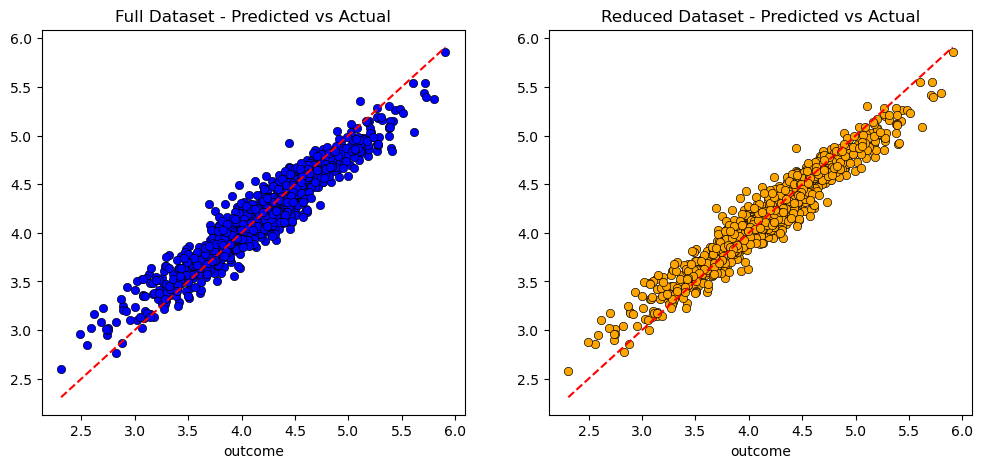

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x=y_test_full, y=y_pred_rf_full, ax=axes[0], color="blue", edgecolor="black")
axes[0].plot([y_test_full.min(), y_test_full.max()], [y_test_full.min(), y_test_full.max()], '--r', linewidth=1.5)
axes[0].set_title("Full Dataset - Predicted vs Actual")

sns.scatterplot(x=y_test_reduced, y=y_pred_rf_reduced, ax=axes[1], color="orange", edgecolor="black")
axes[1].plot([y_test_reduced.min(), y_test_reduced.max()], [y_test_reduced.min(), y_test_reduced.max()], '--r', linewidth=1.5)
axes[1].set_title("Reduced Dataset - Predicted vs Actual")

plt.show()